# Tutorial 3: Integrating slices across sequencing platforms
This tutorial demonstrates STAligner's ablility to remove batch effects between different sequencing platforms. 

Here, We use the mouse olfactory bulb data generated by Stereo-seq and Slide-seqV2. The processed Stereo-seq and Slide-seqV2 data can be downloaded from https://drive.google.com/drive/folders/1Omte1adVFzyRDw7VloOAQYwtv_NjdWcG?usp=share_link.

## Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import ST_utils
# import train_STAligner
import STAligner

# the location of R (used for the mclust clustering)
import os
os.environ['R_HOME'] = "/home/xzhou/anaconda3/envs/PyG/lib/R"
os.environ['R_USER'] = "/home/xzhou/anaconda3/envs/PyG/lib/python3.8/site-packages/rpy2"
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri


import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import scipy.linalg
from scipy.sparse import csr_matrix

import torch
used_device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

## Load Data

In [3]:
Batch_list = []
adj_list = []
section_ids = ['Stereo-seq','Slide-seqV2']
print(section_ids)

for section_id in section_ids:
    print(section_id)
    adata = sc.read_h5ad(os.path.join('Data/', section_id + '.h5ad'))
    adata.X = csr_matrix(adata.X)
    adata.var_names_make_unique(join="++")
    print('Before flitering: ', adata.shape)
    sc.pp.filter_genes(adata, min_cells=50)
    print('After flitering: ', adata.shape)

    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]    
    
    # Constructing the spatial network
    STAligner.Cal_Spatial_Net(adata, rad_cutoff=50) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
    
    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=5000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    adata = adata[:, adata.var['highly_variable']]
    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)


['Stereo-seq', 'Slide-seqV2']
Stereo-seq
Before flitering:  (19109, 27106)
After flitering:  (19109, 14376)
------Calculating spatial graph...
The graph contains 144318 edges, 19109 cells.
7.5524 neighbors per cell on average.
Slide-seqV2
Before flitering:  (20139, 21220)
After flitering:  (20139, 11750)
------Calculating spatial graph...
The graph contains 228288 edges, 20139 cells.
11.3356 neighbors per cell on average.


## Concat the scanpy objects for multiple slices

In [4]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (39248, 1506)


## Concat the spatial network for multiple slices

In [5]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(section_ids)):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat) 

## Running STAligner

In [6]:
%%time
adata_concat = STAligner.train_STAligner(adata_concat, verbose=True, knn_neigh = 100, device=used_device) #epochs = 1500,

STAligner(
  (conv1): GATConv(1506, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 1506, heads=1)
)
Pretrain with STAGATE...


100%|██████████| 500/500 [00:29<00:00, 16.89it/s]


Train with STAligner...


  0%|          | 0/500 [00:00<?, ?it/s]

Update spot triplets at epoch 500


 20%|█▉        | 99/500 [00:15<00:25, 15.81it/s] 

Update spot triplets at epoch 600


 40%|███▉      | 199/500 [00:36<00:19, 15.32it/s]

Update spot triplets at epoch 700


 60%|█████▉    | 299/500 [01:00<00:12, 15.95it/s]

Update spot triplets at epoch 800


 80%|███████▉  | 399/500 [01:25<00:07, 13.90it/s]

Update spot triplets at epoch 900


100%|██████████| 500/500 [01:51<00:00,  4.49it/s]


CPU times: user 4min 43s, sys: 13.9 s, total: 4min 57s
Wall time: 2min 25s


## Clustering

In [7]:
sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
sc.tl.louvain(adata_concat, random_state=666, key_added="louvain", resolution=0.5)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Visualization

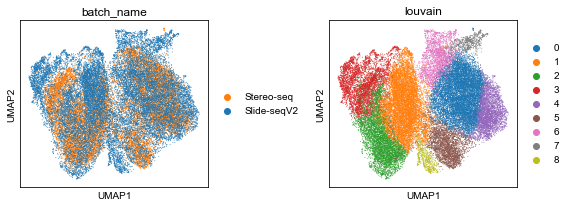

In [8]:
sc.tl.umap(adata_concat, random_state=666)

section_color = ['#ff7f0e', '#1f77b4']
section_color_dict = dict(zip(section_ids, section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams['font.size'] = 10

sc.pl.umap(adata_concat, color=['batch_name', 'louvain'], ncols=2, wspace=0.5, show=True)

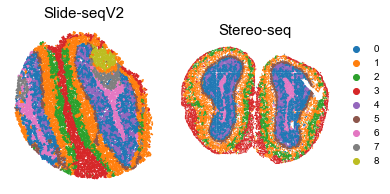

In [9]:
import matplotlib.pyplot as plt
spot_size = 50
title_size = 15
fig, ax = plt.subplots(1, 2, figsize=(6, 3), gridspec_kw={'wspace': 0.05, 'hspace': 0.2})
_sc_0 = sc.pl.spatial(adata_concat[adata_concat.obs['batch_name'] == 'Slide-seqV2'], img_key=None, color=['louvain'], title=['Slide-seqV2'],
                      legend_fontsize=10, show=False, ax=ax[0], frameon=False, spot_size=spot_size, legend_loc=None)
_sc_0[0].set_title('Slide-seqV2', size=title_size) 

_sc_1 = sc.pl.spatial(adata_concat[adata_concat.obs['batch_name'] == 'Stereo-seq'], img_key=None, color=['louvain'], title=['Stereo-seq'],
                      legend_fontsize=10, show=False, ax=ax[1], frameon=False, spot_size=spot_size)
_sc_1[0].set_title('Stereo-seq',size=title_size)
_sc_1[0].invert_yaxis()
plt.show()